In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import hfmfit as hf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate as 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "mlr_hier_cov"
rank = 30
n = 5000
signal_to_noise = 4


nsamples = 300
L = 6

ranks = np.array([14, 6, 4, 3, 2, 1])

In [4]:
hpart = mf.random_hpartition(n, n, level_list=list(range(L-1)) + [int(np.ceil(np.log2(n)))], symm=True, perm=True)
part_sizes = hf.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=5000.0
level=1, num_groups=2, mean_size=2500.0
level=2, num_groups=4, mean_size=1250.0
level=3, num_groups=8, mean_size=625.0
level=4, num_groups=16, mean_size=312.5
level=5, num_groups=5000, mean_size=1.0


In [5]:
true_mlr, true_sparse_F, true_D_noise = hf.generate_mlr_model(n, hpart, ranks, signal_to_noise)

signal_var=28.95142542915701, noise_var=7.150831628949085
SNR=4.048679500710301, signal_to_noise=4


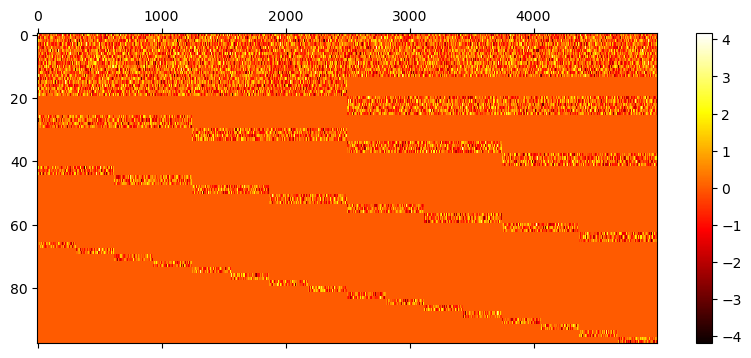

(5000, 98)


In [6]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [7]:
C = hf.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)

Z = (C - C.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]

# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

In [8]:
ntest = 10**4
C_test = hf.generate_data(true_sparse_F, true_D_noise, ntest, true_mlr)

Z_test = (C_test - C_test.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
# A_test = (Z_test @ Z_test.T / (Z_test.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]

# permute to put clusters on diagonal
Y_test = Z_test.T

In [9]:
type(true_sparse_F)

numpy.ndarray

In [10]:
perm_true_covariance = true_sparse_F @ true_sparse_F.T + np.diag(true_D_noise)
np.linalg.norm(unpermuted_A[hpart["rows"]["pi"], :][:, hpart["rows"]["pi"]] - perm_true_covariance, 'fro') / np.linalg.norm(perm_true_covariance, 'fro') 

0.48388333573699105

In [11]:
C.shape, Z.shape, unpermuted_A.shape

((5000, 300), (5000, 300), (5000, 5000))

In [12]:
U, Vt, sigmas = mf.frob_low_rank(unpermuted_A)
frob_losses = np.zeros(n)
normalization = np.linalg.norm(unpermuted_A, ord='fro')
# assert np.allclose(normalization, ((sigmas**2).sum())**0.5)
sigmas2 = (sigmas**2)[::-1]
frob_losses = np.concatenate([(np.cumsum(sigmas2)**0.5)[::-1][1:] / normalization, np.array([0])])

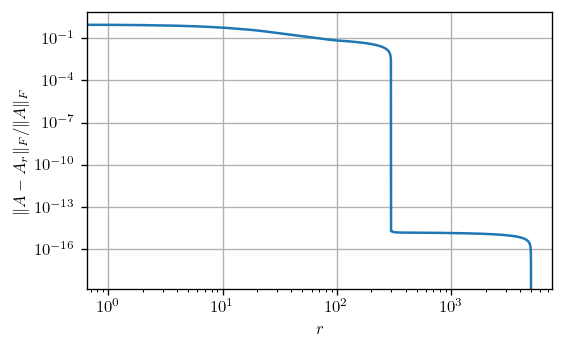

In [13]:
mf.plot_frob_error_rank(frob_losses)

In [14]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [15]:
row_selectors, si_groups, F_hpart = hf.row_col_selections(hpart)

num_levels=6, num_sparsities=16
(16, 5) [ 0  1  3  7 15]


# True model loglikelihoods

In [16]:
true_Sigma = hf.perm_hat_Sigma_sp(true_sparse_F, true_D_noise)
tr_lu, tr_piv = scipy.linalg.lu_factor(true_Sigma)
true_test_obj = hf.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y_test)
true_train_obj = hf.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y)
exp_true_obj_test = hf.exp_true_loglikelihood_value(true_Sigma)
print(f"TR: train ll={true_train_obj}, test ll={true_test_obj}, {exp_true_obj_test=}")

TR: train ll=-11534.532534471697, test ll=-11535.729803239246, exp_true_obj_test=-11536.310803584467


In [43]:
hf.exp_loglikelihood_value(true_Sigma, true_Sigma, tr_lu, tr_piv)

-11536.310803584467

In [41]:
np.linalg.slogdet(true_Sigma)

(1.0, 8883.23627512221)

# Frobenius nodem-based loss

In [46]:
obj_frobs = {}

print(ranks.sum())
hat_A = mf.MLRMatrix()
hat_A.hpart = hpart
losses = hat_A.factor_fit(unpermuted_A, ranks, hat_A.hpart, eps_ff=1e-3, PSD=True, freq=1, \
                                printing=True, max_iters_ff=50, symm=True)

F_frob, D_frob = hat_A.B[:, :-1], np.square(hat_A.B[:, -1])
Sigma_frob = hf.perm_hat_Sigma(F_frob, D_frob, F_hpart, ranks)
frob_lu, frob_piv = scipy.linalg.lu_factor(Sigma_frob)
obj_frob = hf.loglikelihood_value(Sigma_frob, frob_lu, frob_piv, Y)

obj_frob_test = hf.loglikelihood_value(Sigma_frob, frob_lu, frob_piv, Y_test)
print(f"FR: train ll={obj_frob}, test ll={obj_frob_test}, {losses[-1]=}")
obj_frobs[str(ranks)] = {"train":obj_frob, "test":obj_frob_test}

30
itr=0, 0.2634191004275578, [14  6  4  3  2  1]
itr=1, 0.2634191004275578, [14  6  4  3  2  1]
itr=1, 0.22817724088024638, [14  6  4  3  2  1], time_v_epoch=15.759416103363037, time_loss=0.9360060691833496
itr=2, 0.2203841985332227, [14  6  4  3  2  1], time_v_epoch=14.358222723007202, time_loss=0.9115641117095947
itr=3, 0.2171040805027495, [14  6  4  3  2  1], time_v_epoch=16.588304042816162, time_loss=0.8048348426818848
itr=4, 0.21574939292963735, [14  6  4  3  2  1], time_v_epoch=15.276301860809326, time_loss=0.9960980415344238
itr=5, 0.2151926765427125, [14  6  4  3  2  1], time_v_epoch=14.328355073928833, time_loss=0.9148349761962891
itr=6, 0.21496258463511614, [14  6  4  3  2  1], time_v_epoch=14.797704219818115, time_loss=0.907839298248291
itr=7, 0.2148665241339222, [14  6  4  3  2  1], time_v_epoch=15.812405109405518, time_loss=0.8170218467712402
FR: train ll=-11293.696152145672, test ll=-11882.505048194358, losses[-1]=0.21484197914796496


In [47]:
hf.exp_loglikelihood_value(true_Sigma, Sigma_frob, frob_lu, frob_piv)

-11884.339729997173

In [48]:
print(f"FR: train ll={obj_frob}, test ll={obj_frob_test}, {losses[-1]=}")

FR: train ll=-11293.696152145672, test ll=-11882.505048194358, losses[-1]=0.21484197914796496


In [19]:
mf.rel_diff(hat_A.matrix(), den=unpermuted_A), np.linalg.slogdet(hat_A.matrix())

(0.21484197914796554, (1.0, 8429.99961314151))

# MLE-based loss

In [20]:
loglikelihoods, F0, D0 = hf.em_algorithm(n, Y, part_sizes, F_hpart, row_selectors, si_groups, ranks, max_iter=1200, 
                eps=1e-8, printing=True) 

t=0, obj=-15828.549017611631
t=50, obj=-11533.581910212471
t=100, obj=-11313.220811484338
t=150, obj=-11299.1906604034
t=200, obj=-11292.031827362725
t=250, obj=-11287.37800945753
t=300, obj=-11284.116753747974
t=350, obj=-11281.7122080417
t=400, obj=-11279.872004812287
t=450, obj=-11278.422947523131
t=500, obj=-11277.256088189244
t=550, obj=-11276.299497270065
t=600, obj=-11275.503724807597
t=650, obj=-11274.833604467223
t=700, obj=-11274.263412858747
t=750, obj=-11273.773886887722
t=800, obj=-11273.350314198085
t=850, obj=-11272.981268373962
t=900, obj=-11272.657746012332
t=950, obj=-11272.372562762937
t=1000, obj=-11272.119921274669
t=1050, obj=-11271.895096262582
t=1100, obj=-11271.694201187203
t=1150, obj=-11271.51401291691
t=1199, obj=-11271.354920517051


In [21]:
D0.shape

(5000,)

In [22]:
ll_hier = np.copy(np.array(loglikelihoods))

In [23]:
Sigma0 = hf.perm_hat_Sigma(F0, D0, F_hpart, ranks)
mf.rel_diff(Sigma0, den=unpermuted_A[hat_A.pi_rows, :][:, hat_A.pi_cols]), np.linalg.slogdet(Sigma0)

(0.4766926932985976, (1.0, 8342.107804992786))

In [44]:
mle_lu, mle_piv = scipy.linalg.lu_factor(Sigma0)
obj_test = hf.loglikelihood_value(Sigma0, mle_lu, mle_piv, Y_test)

print(f"ML: train ll={loglikelihoods[-1]}, test ll={obj_test}")
ll_hier = {"train":ll_hier, "test":obj_test}

ML: train ll=-11271.354920517051, test ll=-11860.720865902955


In [45]:
hf.exp_loglikelihood_value(true_Sigma, Sigma0, mle_lu, mle_piv)

-11862.427409210677

In [25]:
# ML: train ll=-11271.354920517051, test ll=-11860.720865902955

In [26]:
obj_frobs

{'[14  6  4  3  2  1]': {'train': -11293.696152145674,
  'test': -11882.505048194353}}

In [27]:
with open(f"outputs/em_{mtype}.pickle", 'wb') as handle:
    lls = {"hier":ll_hier, "frob":obj_frobs}
    pickle.dump(lls, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
# true model maximizes the likelihood of test data
assert exp_true_obj_test > obj_frobs[str(ranks)]["test"] and exp_true_obj_test > ll_hier["test"]
print(exp_true_obj_test, ll_hier["test"], obj_frobs[str(ranks)]["test"])

-11536.310803584467 -11860.720865902955 -11882.505048194353


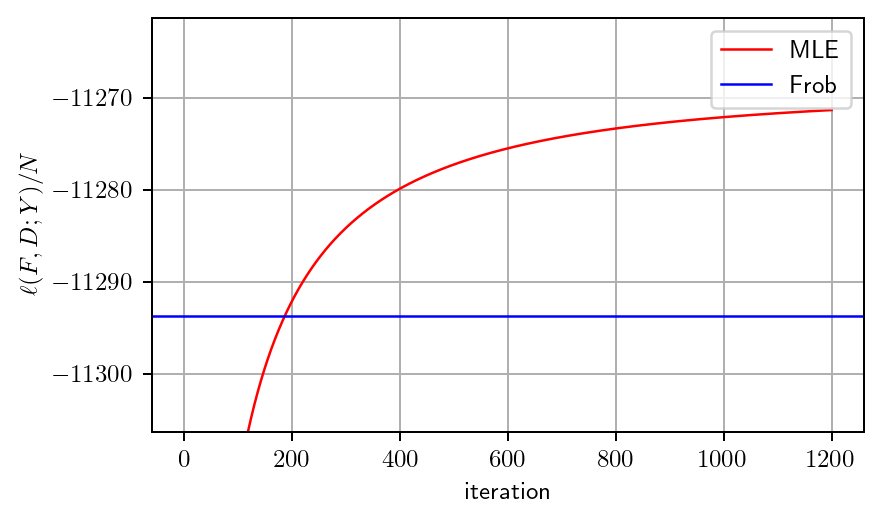

In [38]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=180, sharey=True)

ll = ll_hier["train"][1:]
# print(f"{ranks=}, difference={(ll[-1]-obj_frobs[str(ranks)]["train"]):.2f}, %increase={(ll[-1]-obj_frobs[str(ranks)]["train"])/obj_frobs[str(ranks)]["train"]*100:.2f}")
axs.plot(ll, color='r', lw=1, label=r"$\text{MLE}$")
axs.set_xlabel('iteration')
axs.axhline(obj_frobs[str(ranks)]["train"], 0, ll.size-1, color='b', lw=1, label=r"$\text{Frob}$")
axs.set_ylabel(r'$\ell(F, D; Y)/N$')
# axs.set_yscale('symlog')
axs.set_ylim([ll.max() - 35, ll.max() + 10])
# axs.axhline(y=true_test_obj, label='True', c='g', alpha=0.5)
axs.grid(True)
axs.legend()
    # axs[i].set_title(f"ranks$={list(ranks)}$")
# plt.show()
plt.tight_layout()
plt.savefig(f"plots/em_{mtype}.pdf", bbox_inches='tight')

In [30]:
assert Z.shape[1] == nsamples

In [31]:
np.linalg.slogdet(hat_A.matrix())

(1.0, 8429.99961314151)

In [40]:
-11271 + 11294, -11861 + 11883

(23, 22)